In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from math import nan
import seaborn as sns

from meegkit.detrend import detrend

from pyod import models
from pyod.models import hbos
from sklearn.metrics import (confusion_matrix,cohen_kappa_score,
                             f1_score, multilabel_confusion_matrix, 
                             accuracy_score,confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score,classification_report,
                             r2_score)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn import datasets, svm


In [108]:
import glob
SSVEPfilepath='/Users/tracy/Desktop/Neuroengineer-2024-main/EEG/eeg_data-3/SSVEP/'
Runs = glob.glob(SSVEPfilepath+'*.parquet')

In [109]:
def PreprocessingSSVEP(df, NotchFreqs, l_freq, h_freq):
    df=df.rename(columns={'o1': 'O1', 'o2':'O2','t3':'T3','t4':'T4'})
    eegdata=df.drop(['i','timestamp','event_id','eeg_counter'],axis=1)
    eegdata=eegdata.dropna()
    raweeg_array=eegdata[['O1', 'O2','T3','T4']].values.transpose()
    
    Channel_name=list(eegdata.columns)
    #df['event_id'].unique() 

    n_channels=len(eegdata.columns) 
    
    info=mne.create_info(
          ch_names=Channel_name,
          ch_types=['eeg']*n_channels,
          sfreq=256,
          )
    info.set_montage('standard_1020')
    raw=mne.io.RawArray(eegdata.T, info)
    sfreq=raw.info["sfreq"]
    
    X = raw.get_data().T # transpose so the data is organized time-by-channels
    X, _, _ = detrend(X, order=1)
    X, _, _ = detrend(X, order=6)
    raw_detrend = raw.copy()
    raw_detrend._data = X.T  # overwrite raw data
    
    #NotchFreqs = (51.5, 68.1,103)
    raw_notch=raw_detrend.copy().notch_filter(freqs=NotchFreqs,filter_length='auto', phase='zero')
    raw_filtered=raw_notch.copy().filter(l_freq=l_freq, h_freq=h_freq, fir_design="firwin", skip_by_annotation="edge")
    
    return raw_filtered   

def Get_Evoke(df,sfreq, raw_filtered):
    eegdata=df.drop(['i','timestamp','event_id','eeg_counter'],axis=1)
    n_channels=len(eegdata.columns)
    event_id={1: 'Stim7.5',
              2: 'Stim8.57',
              3: 'Stim10',
              4: 'Stim12',
              #1001:'Res7.5',
              # #1002:'Res8.57',
              # #1003:'Res10',
              # #1004:'Res12',
              # #999:'Resno',
              }
    event_id=dict( Stim1=1, Stim2=2, Stim3=3,Stim4=4) #, Resp1=10001, Resp2=1002, Resp3=1003, Resp4=1004) #Start=10000, End=10001)
    event_id=event_id
    
    events_interest=np.where(df['event_id']<5)[0] 
    events_interest

    # P300: -0.2-2s
    # Create events array information [sample onsets, zeros, labels]
    event_length=round(2.2*sfreq)
    event_length
    np.zeros(len(events_interest), dtype=int)

    labels=[]
    for i in events_interest:
        label=int(df['event_id'].iloc[i])
        labels.append(label)

    labels=np.array(labels)
    events=np.column_stack((events_interest, 
                            np.zeros(len(events_interest), dtype=int), 
                            labels))
    epochs = mne.Epochs(raw_filtered, events, tmin=-0.2, tmax=2)
    epochs.event_id = event_id   
    epochs_array=epochs.get_data().transpose(1,2,0)
   
    return epochs, events, labels, epochs_array


In [110]:
from scipy import signal,integrate
from scipy.signal import welch
from scipy.integrate import simps


def lyapunov(eegData):
    return np.mean(np.log(np.abs(np.gradient(eegData,axis=0))),axis=1)

# def bandPower(eegData, lowcut, highcut, fs):
    # nyq = 0.5 * fs
    # low = lowcut / nyq
    # high = highcut / nyq
    # b, a = scipy.signal.butter(7, [low, high], btype='band')
    # filt_eegData = scipy.signal.lfilter(b, a, eegData, axis = 1)
    # freqs, powers = scipy.signal.periodogram(filt_eegData, fs, axis=1)
    # bandPwr = np.mean(powers,axis=1)
    # return bandPwr

def medianFreq(eegData,fs):
    H = np.zeros((eegData.shape[0], eegData.shape[2]))
    for chan in range(H.shape[0]):
        freqs, powers = scipy.signal.periodogram(eegData[chan, :, :], fs, axis=0)
        H[chan,:] = freqs[np.argsort(powers,axis=0)[len(powers)//2]]
    return H

def hjorthParameters(xV):
    dxV = np.diff(xV, axis=1)
    ddxV = np.diff(dxV, axis=1)

    mx2 = np.mean(np.square(xV), axis=1)
    mdx2 = np.mean(np.square(dxV), axis=1)
    mddx2 = np.mean(np.square(ddxV), axis=1)

    mob = mdx2 / mx2
    complexity = np.sqrt((mddx2 / mdx2) / mob)
    mobility = np.sqrt(mob)

    # PLEASE NOTE that Mohammad did NOT ACTUALLY use hjorth complexity,
    # in the matlab code for hjorth complexity subtraction by mob not division was used 
    return mobility, complexity

def bandpower(eegData, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    
    arr = []
    for chan in range(eegData.shape[0]):
        arr.append([])
        for i in range(eegData.shape[2]):
            data= eegData[chan][:,i]
            band = np.asarray(band)
            low, high = band

            # Define window length
            if window_sec is not None:
                nperseg = window_sec * sf
            else:
                nperseg = (2 / low) * sf

            # Compute the modified periodogram (Welch)
            freqs, psd = welch(data, sf, nperseg=nperseg)

            # Frequency resolution
            freq_res = freqs[1] - freqs[0]

            # Find closest indices of band in frequency vector
            idx_band = np.logical_and(freqs >= low, freqs <= high)

            # Integral approximation of the spectrum using Simpson's rule.
            bp = simps(psd[idx_band], dx=freq_res)

            if relative:
                bp /= simps(psd, dx=freq_res)
            arr[chan].append(bp)
    arr=np.array(arr)
    return arr

def SSVEP_feature_eatraction(epochs_array, sfreq):    
        #Complexity features
        LyapunovRes=np.mean(np.log(np.abs(np.gradient(epochs_array,axis=1))),axis=1)
        Mobility, Complexity=hjorthParameters(epochs_array)
        
        #Continuity features
        MedFreq=medianFreq(epochs_array, sfreq)
        
        # δ band Power
        bandPwr_delta = bandpower(epochs_array/(10**-6), sfreq, (0.5, 4), window_sec=None, relative=False)
        #bandPwr_delta=bandPower(epochs_array/(10**-6), 0.5, 4, 256)        
        # θ band Power
        bandPwr_theta = bandpower(epochs_array/(10**-6), sfreq, (4, 8), window_sec=None, relative=False)
        #bandPwr_theta = bandPower(epochs_array/(10**-6), 4, 8, 256)
        # α band Power
        bandPwr_alpha = bandpower(epochs_array/(10**-6), sfreq, (8, 12), window_sec=None, relative=False)
        #bandPwr_alpha = bandPower(epochs_array/(10**-6), 8, 12, 256)
        # β band Power
        bandPwr_beta = bandpower(epochs_array/(10**-6), sfreq, (12, 30), window_sec=None, relative=False)
        #bandPwr_beta = bandPower(epochs_array/(10**-6), 12, 30, 256)
        # γ band Power
        bandPwr_gamma = bandpower(epochs_array/(10**-6), sfreq, (30, 100), window_sec=None, relative=False)
        #bandPwr_gamma = bandPower(epochs_array/(10**-6), 30, 100, 256)
        
        features=np.concatenate((LyapunovRes,Mobility,Complexity, MedFreq,
                                 #bandPwr_delta, 
                                 bandPwr_theta, bandPwr_alpha, bandPwr_beta,
                                 bandPwr_gamma),axis=0).transpose()
        return features

In [111]:
from scipy.sparse import csr_matrix
from scipy.sparse import vstack

Notch=(51.5, 68.1,103)
AllFeatures=[] 
AllLabels=[]

for i in range(len(Runs)):
    df=pd.read_parquet(Runs[i])
    raw_filtered=PreprocessingSSVEP(df,Notch,l_freq=7, h_freq=30)
    sfreq=raw_filtered.info['sfreq']
    subj_nb, rec_nb = int(1), int(Runs[i][-9:-8])
    raw_filtered.info['subject_info']={"id":subj_nb,'rec_id':rec_nb}
    epochs, events, labels, epochs_array=Get_Evoke(df,sfreq, raw_filtered)
    features=SSVEP_feature_eatraction(epochs_array, sfreq)
       
    a=csr_matrix(features)  
    AllFeatures=vstack((AllFeatures,a),format='csr')
    AllFeatures=AllFeatures.toarray()
    AllLabels=np.concatenate([AllLabels, labels])   
    
AllFeatures=AllFeatures[1:]

Creating RawArray with float64 data, n_channels=4, n_times=24108
    Range : 0 ... 24107 =      0.000 ...    94.168 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
6 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
11

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
9 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
10

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
15

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
7 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
10

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
6 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
9 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
5 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
14

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
6 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)

Not setting metadata
11

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 564, using nperseg = 564
  warnings.warn('nperseg = {0:d} is greater than input length '


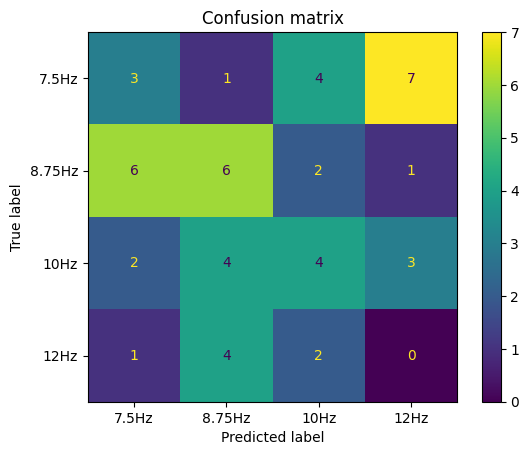

accuracy: 0.26.
r2 score: -1.30.
r2 score: -1.30.
              precision    recall  f1-score   support

         1.0       0.20      0.25      0.22        12
         2.0       0.40      0.40      0.40        15
         3.0       0.31      0.33      0.32        12
         4.0       0.00      0.00      0.00        11

    accuracy                           0.26        50
   macro avg       0.23      0.25      0.24        50
weighted avg       0.24      0.26      0.25        50



In [128]:
X=AllFeatures
y=AllLabels
name=['1','2','3','4']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.4)

classifier = svm.SVC(kernel="linear", C=0.1).fit(X_train, y_train)

np.set_printoptions(precision=2)

 # Plot non-normalized confusion matrix

disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)
disp.ax_.set_title('Confusion matrix')
disp.ax_.xaxis.set_ticklabels(['7.5Hz', '8.75Hz',  '10Hz', '12Hz']); 
disp.ax_.yaxis.set_ticklabels(['7.5Hz', '8.75Hz',  '10Hz', '12Hz']);

plt.show()

y_pred=classifier.predict(X_test)
print('accuracy: {0:.2f}.'.format(accuracy_score(y_pred, y_test)))
print('r2 score: {0:.2f}.'.format(r2_score(y_pred, y_test)))
print('r2 score: {0:.2f}.'.format(r2_score(y_pred, y_test)))
print(classification_report(y_pred, y_test))

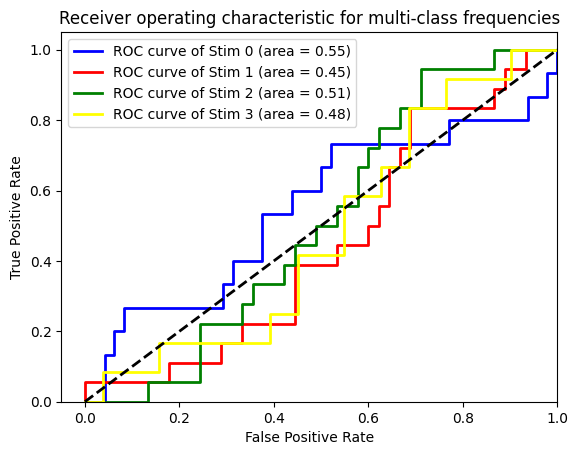

In [129]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import roc_curve, auc


# Binarize the output
y = label_binarize(y, classes=[1,2,3,4])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)


classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of Stim {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class frequencies')
plt.legend(loc="upper left")
plt.show()


In [560]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate 
from pyod import models
from pyod.models import hbos
from sklearn.metrics import confusion_matrix,cohen_kappa_score,f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score,confusion_matrix,ConfusionMatrixDisplay,f1_score,classification_report,r2_score)
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns

from sklearn import datasets, svm
from sklearn.metrics import ConfusionMatrixDisplay

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import mne
from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver="liblinear"),  # liblinear is faster than lbfgs
)
X = epochs.get_data(copy=False)  # MEG signals: n_epochs, n_meg_channels, n_times
y = labels # target: auditory left vs visual left

scores = cross_val_multiscore(clf, X, y, cv=4, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print(f"Spatio-temporal: {100 * score:0.1f}%")


Using data from preloaded Raw for 11 events and 564 original time points ...
Spatio-temporal: 29.2%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [562]:
csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(csp, LinearModel(LogisticRegression(solver="liblinear")))
scores = cross_val_multiscore(clf_csp, X, y, cv=4, n_jobs=None)
print(f"CSP: {100 * scores.mean():0.1f}%")
scores

Computing rank from data with rank=None
    Using tolerance 5.6e-07 (2.2e-16 eps * 4 dim * 6.3e+08  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-07 (2.2e-16 eps * 4 dim * 1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors


Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-07 (2.2e-16 eps * 4 dim * 1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-07 (2.2e-16 eps * 4 dim * 3.8e+08  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.6e-07 (2.2e-16 eps * 4 dim * 6.3e+08  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9e-07 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


    Using tolerance 9.7e-07 (2.2e-16 eps * 4 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-07 (2.2e-16 eps * 4 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
CSP: 16.7%


array([0.33, 0.33, 0.  , 0.  ])

Computing rank from data with rank=None
    Using tolerance 6.6e-07 (2.2e-16 eps * 4 dim * 7.4e+08  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7e-07 (2.2e-16 eps * 4 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-07 (2.2e-16 eps * 4 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-07 (2.2e-16 eps * 4 dim * 3.8e+08  max singular value)
    Estimated rank 

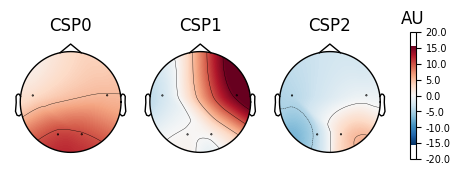

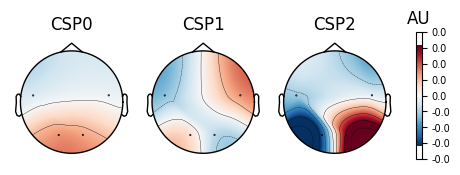

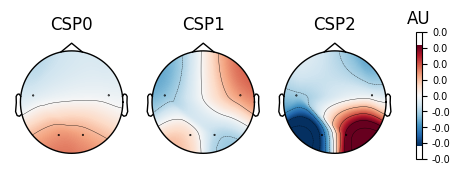

In [557]:
csp.fit(X, y)
csp.plot_patterns(epochs.info)
csp.plot_filters(epochs.info, scalings=1e-9)

In [611]:
#a=epochs_array.transpose(2,0,1)
data=np.mean(epochs_array.transpose(2,0,1), axis=1)

#epochs_train = data.copy().crop(tmin=1.0, tmax=2.0)
#labels = epochs.events[:, -1] - 2

Deep learning

In [13]:
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')

No GPU found. Training will be carried out on CPU, which might be slower.

If running on Google Colab, you can request a GPU runtime by clicking
`Runtime/Change runtime type` in the top bar menu, then selecting 'GPU'
under 'Hardware accelerator'.


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
from torch.utils.data import Dataset, ConcatDataset

class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.
    
    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, 
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)
    
    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y
    

def scale(X):
    """Standard scaling of data along the last dimention.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [24]:
# Load recordings
raws = [PreprocessingSSVEP(pd.read_parquet(i), Notch,l_freq=0.5, h_freq=45) for i in Runs]

for i in range(len(Runs)):
     subj_nb, rec_nb = int(1), int(Runs[i][-9:-8])
     raws[i].info['subject_info']={"id":subj_nb,'rec_id':rec_nb}

Creating RawArray with float64 data, n_channels=4, n_times=24108
    Range : 0 ... 24107 =      0.000 ...    94.168 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Uppe

In [25]:
def extract_epochs(i):
    epochs=Get_Evoke(pd.read_parquet(Runs[i]),sfreq, raws[i])[0]
    labels=Get_Evoke(pd.read_parquet(Runs[i]),sfreq, raws[i])[2]
    return epochs, labels

In [26]:
# Apply windowing and move to pytorch dataset
all_datasets = [EpochsDataset(*extract_epochs(i), subj_nb=raws[i].info['subject_info']['id'], 
                              rec_nb=raws[i].info['subject_info']['rec_id'],
                               transform=scale) 
                 for i in range(len(Runs))]

# # Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)


Not setting metadata
6 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 564 original time points ...
0 bad epochs dropped
Not setting metadata
6 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 564 original time points ...
0 bad epochs dropped


Not setting metadata
6 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 564 original time points ...
0 bad epochs dropped
Not setting metadata
6 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 564 original time points ...
0 bad epochs dropped
Not setting metadata
11 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11 events and 564 original time points ...
0 bad epochs dropped
Not setting metadata
11 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11 event

In [27]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):
    """Pick recordings using subject and recording numbers.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to pick recordings from.        
    subj_rec_nbs : list of tuples
        List of pairs (subj_nb, rec_nb) to use in split.
        
    Returns
    -------
    ConcatDataset
        The picked recordings.
    ConcatDataset | None
        The remaining recordings. None if all recordings from 
        `dataset` were picked.
    """
    pick_idx = list()
    for rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)
                
    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None
    
    return pick_ds, remaining_ds

def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split dataset into train and test keeping n_groups out in test.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb' | 'rec_nb'
        Property to use to split dataset.
        
    Returns
    -------
    ConcatDataset
        The training data.
    ConcatDataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])
        
    return train_ds, test_ds

In [712]:
# We seed the random number generators to make our splits reproducible
torch.manual_seed(87)
np.random.seed(87)

In [65]:
pick_ds = ConcatDataset([dataset.datasets[i] for i in range(3)])
remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), range(3))
if len(remaining_idx) > 0:
    remaining_ds = ConcatDataset(
        [dataset.datasets[i] for i in remaining_idx])
else:
    remaining_ds = None
pick_ds, remaining_ds
# Use recording 0-8 of subjects 1 as test set
test_ds=pick_ds
train_ds =remaining_ds


pick_ds2 = ConcatDataset([train_ds.datasets[i] for i in range(3)])
remaining_idx = np.setdiff1d(
        range(len(train_ds.datasets)), range(3))
if len(remaining_idx) > 0:
    remaining_ds = ConcatDataset(
        [train_ds.datasets[i] for i in remaining_idx])
else:
    remaining_ds = None
pick_ds2, remaining_ds

valid_ds=pick_ds2
train_ds=remaining_ds

In [71]:
#test_ds.datasets
train_ds.datasets
#valid_ds.datasets
#test_ds.datasets


Text(0, 0.5, 'SSVEP')

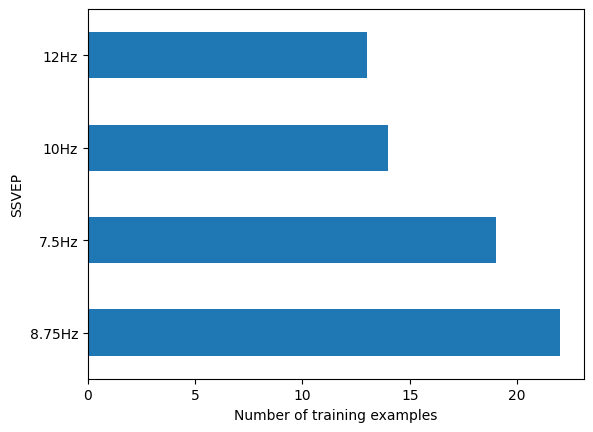

In [72]:
classes_mapping = {1: '7.5Hz', 2: '8.75Hz', 3: '10Hz', 4: '12Hz'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('SSVEP')

In [91]:
np.unique(train_y)

array([1, 2, 3, 4])

In [73]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[0.89 0.77 1.21 1.31]


In [99]:
from torch import nn


class SleepStagerChambon2018(nn.Module):
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=4, input_size_s=2,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )
    @staticmethod
        
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [93]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=4)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [100]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cpu'.


In [101]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 256  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [102]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()
    
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()
        
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()
        
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    
    return np.mean(train_loss), perf


def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()
    
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, 
          patience, device, metric=None):
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()
    
    if metric is None:
        metric = balanced_accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')
                # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [103]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

In [98]:
import copy
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

n_epochs = 1
patience = 1

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience, 
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [68, 1, 1, 4, 564]

In [ ]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))